In [1]:
import sys
import math
import time
import random
sys.path.append("/github/meta_learning/np_variants/")

import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (7.2, 4.8)

In [2]:
dtype = torch.double
device = torch.device("cuda")

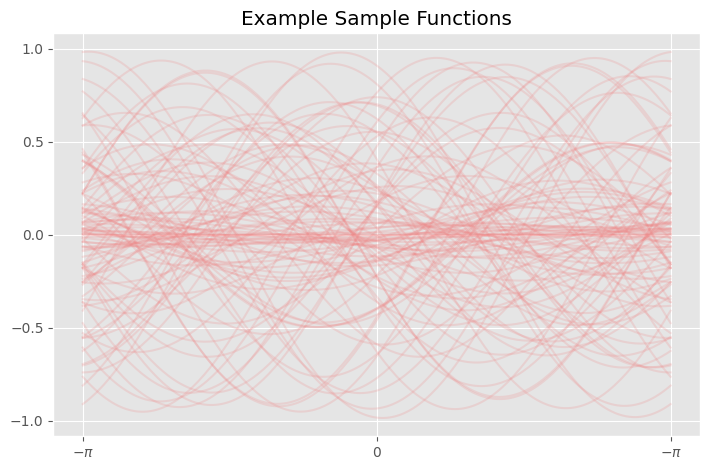

In [3]:
from data.functions_1d import SineFunc

func = SineFunc()
_, _, (amplitude, shift) = func.sample_data(num_tasks=100, num_samples=20)

for i in range(100):
    x = torch.linspace(-math.pi, math.pi, 200)
    y = amplitude[i] * torch.sin((x - shift[i]))
    plt.plot(x.detach().numpy(), y.detach().numpy(), color="lightcoral", alpha=0.2)

plt.xticks(ticks=[-math.pi, 0, math.pi], labels=[r"$-\pi$", r"0", r"$-\pi$"])
plt.yticks(ticks=[-1.0, -0.5, 0, 0.5, 1.0])
plt.title("Example Sample Functions")
plt.tight_layout()

In [4]:
from models.anp import AttentiveNeuralProcess
from models.loss_functions import np_loss_func
from utils import context_target_split

In [5]:
lr = 5e-4
batch_size = 16
num_samples = 200
num_epochs = 5000
print_epoch = 1000

num_context_min = 3
num_context_max = 50
num_extra_target_min = 0
num_extra_target_max = 50

In [6]:
attn_types = ["laplace", "dot_product", "multihead"]
models = {attn_type: AttentiveNeuralProcess(x_dim=1, y_dim=1, attn_type=attn_type, self_attn=True).to(dtype=dtype, device=device) for attn_type in attn_types}
optimizers = {attn_type: optim.Adam(models[attn_type].parameters(), lr=lr) for attn_type in attn_types}
loss_func = np_loss_func

In [7]:
for attn_type in attn_types:
    model = models[attn_type]
    optimizer = optimizers[attn_type]
    print(f"ATTENTION TYPE: {attn_type}")
    start_time = time.time()
    for epoch in range(num_epochs):
        x_batch, y_batch, _ = func.sample_data(batch_size, num_samples)
        x_batch = x_batch.to(dtype=dtype, device=device)
        y_batch = y_batch.to(dtype=dtype, device=device)

        num_context = random.randint(num_context_min, num_context_max)
        num_extra_target = random.randint(num_extra_target_min, num_extra_target_max)

        x_context, y_context, x_target, y_target = context_target_split(x_batch, y_batch, num_context, num_extra_target)

        y_pred, q_context, q_target = model(x_context, y_context, x_target, y_target)
        
        optimizer.zero_grad()
        loss = loss_func(y_pred, y_target, q_context, q_target)
        loss.backward()
        optimizer.step()

        if (epoch+1) % print_epoch == 0:
            end_time = time.time()
            print(f"[{epoch+1}/{num_epochs}]\tLoss: {loss.item() / batch_size :.8f}\tTime: {end_time - start_time :.8f}")
            start_time = end_time
    print("==================================================================================================")

ATTENTION TYPE: laplace
[1000/5000]	Loss: -0.31563275	Time: 30.391058444976807
[2000/5000]	Loss: -3.51473518	Time: 29.322907209396362
[3000/5000]	Loss: -4.90347947	Time: 29.07441282272339
[4000/5000]	Loss: -5.01921688	Time: 29.965975999832153
[5000/5000]	Loss: -4.99116475	Time: 29.591461658477783
ATTENTION TYPE: dot_product
[1000/5000]	Loss: -1.64560538	Time: 24.989983081817627
[2000/5000]	Loss: -4.92820798	Time: 25.593682289123535
[3000/5000]	Loss: -4.95273193	Time: 25.61121678352356
[4000/5000]	Loss: -3.48998889	Time: 26.418418645858765
[5000/5000]	Loss: -0.40317528	Time: 25.872355222702026
ATTENTION TYPE: multihead
[1000/5000]	Loss: -1.90707941	Time: 56.84881639480591
[2000/5000]	Loss: -0.73400195	Time: 55.80707931518555
[3000/5000]	Loss: -1.08371295	Time: 56.20720958709717
[4000/5000]	Loss: -5.54452093	Time: 58.22300863265991
[5000/5000]	Loss: -0.36376665	Time: 57.6953501701355


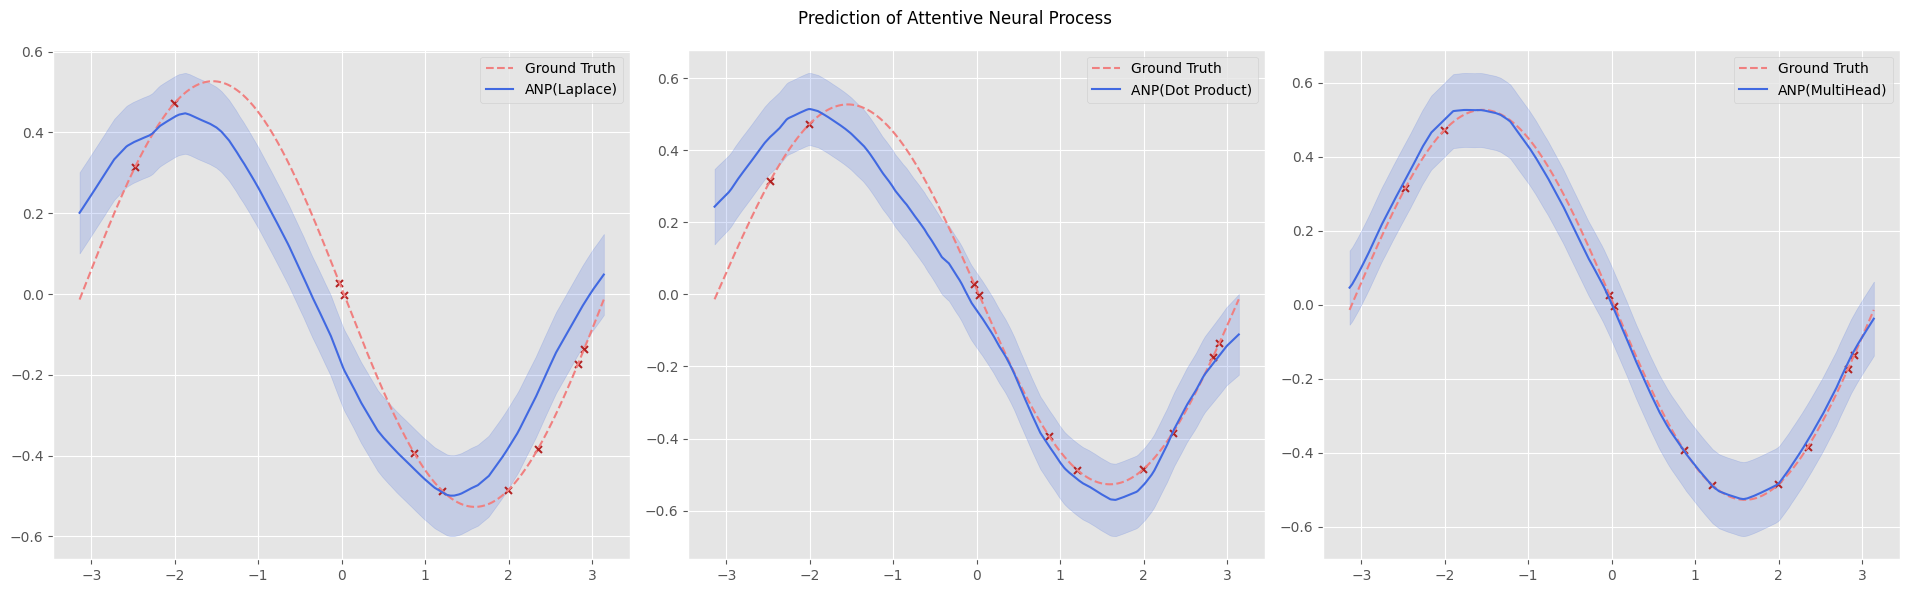

In [9]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(19.2, 6.0))

x_test, y_test, (amplitude, shift) = func.sample_data(num_tasks=1, num_samples=10)
x_grid = torch.linspace(-math.pi, math.pi, 1000)
y_grid = amplitude * torch.sin(x_grid - shift)

y_pred = [models[attn_type](x_test.to(dtype=dtype, device=device), 
                           y_test.to(dtype=dtype, device=device), 
                           x_grid.view(1, 1000, 1).to(dtype=dtype, device=device)) for attn_type in attn_types]

ax0.scatter(x_test.detach().numpy().flatten(), y_test.detach().numpy().flatten(), marker="x", s=25, color="firebrick", zorder=2)
ax0.plot(x_grid.detach().numpy(), y_grid.detach().numpy(), linestyle="--", color="lightcoral", label="Ground Truth")

ax0.plot(x_grid.detach().numpy(), y_pred[0].loc.cpu().detach().numpy().flatten(), color="royalblue", label="ANP(Laplace)")
ax0.fill_between(x_grid.detach().numpy(), y_pred[0].loc.cpu().detach().numpy().flatten() - y_pred[0].scale.cpu().detach().numpy().flatten(),
                                          y_pred[0].loc.cpu().detach().numpy().flatten() + y_pred[0].scale.cpu().detach().numpy().flatten(), color="royalblue", alpha=0.2)

ax1.scatter(x_test.detach().numpy().flatten(), y_test.detach().numpy().flatten(), marker="x", s=25, color="firebrick", zorder=2)
ax1.plot(x_grid.detach().numpy(), y_grid.detach().numpy(), linestyle="--", color="lightcoral", label="Ground Truth")

ax1.plot(x_grid.detach().numpy(), y_pred[1].loc.cpu().detach().numpy().flatten(), color="royalblue", label="ANP(Dot Product)")
ax1.fill_between(x_grid.detach().numpy(), y_pred[1].loc.cpu().detach().numpy().flatten() - y_pred[1].scale.cpu().detach().numpy().flatten(),
                                          y_pred[1].loc.cpu().detach().numpy().flatten() + y_pred[1].scale.cpu().detach().numpy().flatten(), color="royalblue", alpha=0.2)

ax2.scatter(x_test.detach().numpy().flatten(), y_test.detach().numpy().flatten(), marker="x", s=25, color="firebrick", zorder=2)
ax2.plot(x_grid.detach().numpy(), y_grid.detach().numpy(), linestyle="--", color="lightcoral", label="Ground Truth")

ax2.plot(x_grid.detach().numpy(), y_pred[2].loc.cpu().detach().numpy().flatten(), color="royalblue", label="ANP(MultiHead)")
ax2.fill_between(x_grid.detach().numpy(), y_pred[2].loc.cpu().detach().numpy().flatten() - y_pred[2].scale.cpu().detach().numpy().flatten(),
                                          y_pred[2].loc.cpu().detach().numpy().flatten() + y_pred[2].scale.cpu().detach().numpy().flatten(), color="royalblue", alpha=0.2)

ax0.legend()
ax1.legend()
ax2.legend()

plt.suptitle("Prediction of Attentive Neural Process")
plt.tight_layout()